In [61]:
import cv2
import numpy as np
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.transform import rotate
import matplotlib.pyplot as plt

A simplified data augmentation pipeline, to extend and/or normalize data. Usually in datasets the images have different brightness, so you might want to normalize them. 

In the class there are some functionalities, that work with RGB images and some with flattened, ie. 2D images.

In [106]:
class transform_shapes:
    def __init__(self, data):
        self.data = data
        self.h, self.w = data.shape[1:3]
        self.center_x, self.center_y = int(data.shape[1]/2), int(data.shape[2]/2)

    def affine_trans(self, nr_sampl, nr_per_sample, limit = 10, percent = 0.1):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        pts1 = np.float32(np.random.uniform(2, self.rows-limit, (nr_per_sample*nr_sampl,3,2)))
        pts2 = []
        for j, i in enumerate(pts1):
            # print(i)
            pts2.append(np.float32([[np.random.uniform(i[0, 0]*(1-percent), i[0, 0]*(1+percent)), np.random.uniform(i[0, 1]*(1-percent), i[0, 1]*(1+percent))],
                                    [np.random.uniform(i[1, 0]*(1-percent), i[1, 0]*(1+percent)), np.random.uniform(i[1, 1]*(1-percent), i[1, 1]*(1+percent))],
                                    [np.random.uniform(i[2, 0]*(1-percent), i[2, 0]*(1+percent)), np.random.uniform(i[2, 1]*(1-percent), i[2, 1]*(1+percent))]]))
        #     print('pts1', i, '\n pts2', pts2[j])
        # print(np.array(pts2).shape, pts1.shape)
        # pts1 = np.float32([[[5, 5], 
        #                    [20, 5],  
        #                    [5, 20]]]* int(nr_per_sample*nr_sampl))
  
        # pts2 = np.float32([[[1, 10], 
        #                    [20, 5],  
        #                    [10, 25]]]* int(nr_per_sample*nr_sampl)) 
        k=0
        for i in range(nr_sampl):
            for j in range(nr_per_sample):
                
                # print(i,j, k)
                M = cv2.getAffineTransform(pts1[k], pts2[k]) 
                new_samples.append(cv2.warpAffine(self.data[i], M, (self.w, self.h), borderValue=(1.,1.,1.)))
                k+=1   
        return new_samples

    def shift(self, nr_sampl, nr_per_sample, shift_x_min = -5, 
              shift_x_max = 5, shift_y_min = -5, shift_y_max = 5):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        shifts_x = np.random.uniform(shift_x_min, shift_x_max, int(nr_per_sample*nr_sampl))
        shifts_y = np.random.uniform(shift_y_min, shift_y_max, int(nr_per_sample*nr_sampl))
        shifts = np.vstack((shifts_x, shifts_y)).T

        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        k=0
        M = np.dstack((np.array([[[1, 0], [0, 1]]] * int(nr_per_sample*nr_sampl)), shifts))
        for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    new_samples.append(cv2.warpAffine( self.data[i], M[k], (self.w, self.h), borderValue=(1.,1.,1.)))
                    k+=1  
        return new_samples

    def convolve(self, nr_sampl, kernel = np.array([[0,0.1,0],[0.1,0.6,0.1],[0,0.1,0]])):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        for i in range(nr_sampl):
            new_samples.append(np.clip(cv2.filter2D(self.data[i],-1,kernel),0,1))

        return new_samples
    
    def rotate(self, nr_sampl, nr_per_sample, max_ang=360, min_ang=-360, rotate=1, mini = 0.25, maxi = 3):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        scales = np.random.uniform(mini, maxi, (nr_sampl, nr_per_sample)) 
        angles = np.random.uniform(min_ang, max_ang, (nr_sampl, nr_per_sample))
        # angles = np.random.normal(scale = 50, size=(nr_sampl, nr_per_sample))
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        if rotate:
            for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    # print(angles[i][j])
                    rot_mat = cv2.getRotationMatrix2D((self.center_x ,self.center_y), angles[i][j], scales[i][j])
                    new_samples.append(cv2.warpAffine( self.data[i], rot_mat, (self.w, self.h), borderValue=(1.,1.,1.)))
        else:
            for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    # print(angles[i][j])
                    rot_mat = cv2.getRotationMatrix2D((self.center_x,self.center_y), 0, scales[i][j])
                    new_samples.append(cv2.warpAffine( self.data[i], rot_mat, (self.w, self.h), borderValue=(1.,1.,1.)))

        
        return new_samples

    def translate_image(self, nr_sampl, max_trans = 5):
        """
        Use it with RGB image.
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
            translate_x = max_trans*np.random.uniform() - max_trans/2
            translate_y = max_trans*np.random.uniform() - max_trans/2
            translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
            trans = cv2.warpAffine(self.data[i], translation_mat, (self.w, self.h))
            new_samples.append(trans)
        
        return new_samples

    def rotate_image(self, nr_sampl, max_angle =15):
        """
        Use it with RGB image.
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
            rotate_out = rotate(self.data[i], np.random.uniform(-max_angle, max_angle), mode='edge')
            new_samples.append(rotate_out)
        return new_samples

    def projection_transform(self, nr_sampl, max_warp=0.8):
        """
        Use it with RGB image.
        """
        #Warp Location
        d = self.h * 0.3 * np.random.uniform(0,max_warp)
        
        #Warp co-ordinates
        tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
        tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
        bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
        bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
        tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
        tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
        br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
        br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
            
        ##Apply Projection
        transform = ProjectiveTransform()
        transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, self.h - bl_bottom),
                    (self.h - br_right, self.h - br_bottom),
                    (self.h - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, self.h),
                    (self.h, self.h),
                    (self.h, 0)
                )))
       
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
             output_image = warp(self.data[i], transform, output_shape=(self.h, self.w), order = 1, mode = 'edge')
             new_samples.append(output_image)
        return new_samples

def image_brightness_normalisation(image):
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    return image

def preprocess_data_1(X):
    #Remove the mean of data across each channel
    #X = X - np.mean(X_train.mean(axis=(1,2)), axis=0)
    X = X - np.mean(X, axis=0)
    
    X /= np.std(X, axis=0)
    return X
    
def preprocess_data_2(X):

    for i in range(len(X)):
        X[i,:,:,:] = image_brightness_normalisation(X[i,:,:,:])
    X = X/255.0 - 0.5
    return X

def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)


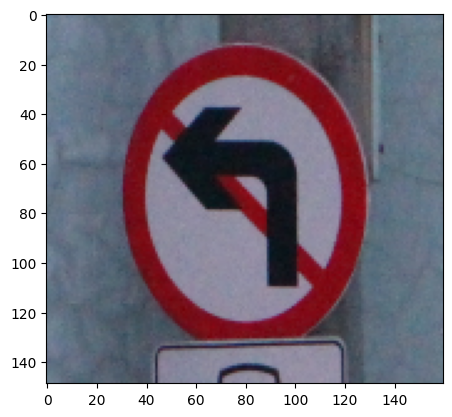

In [107]:
img_path = r'./database/train/A/A_0001.png'
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])
plt.show()

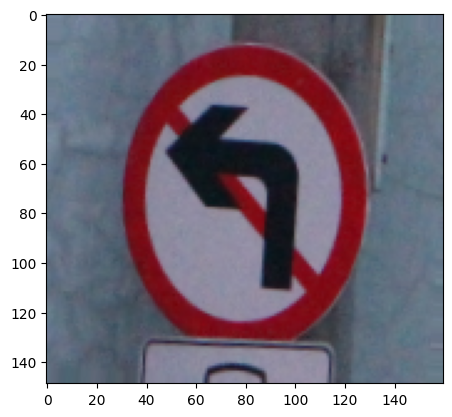

In [108]:
plt.imshow(transform_shapes(np.array([img])).rotate_image(1)[0][:,:,::-1])

In [109]:
tuple((5, *img.shape[:2]))

(5, 149, 160)

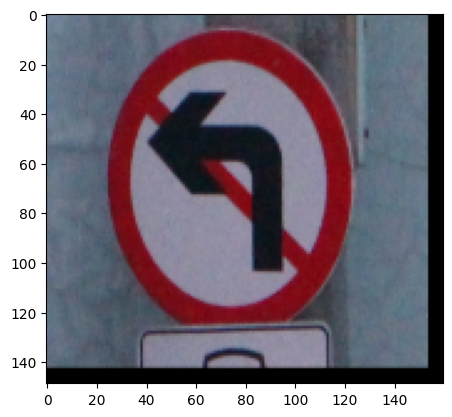

In [110]:
plt.imshow(transform_shapes(np.array([img])).translate_image(1,25)[0][:,:,::-1])

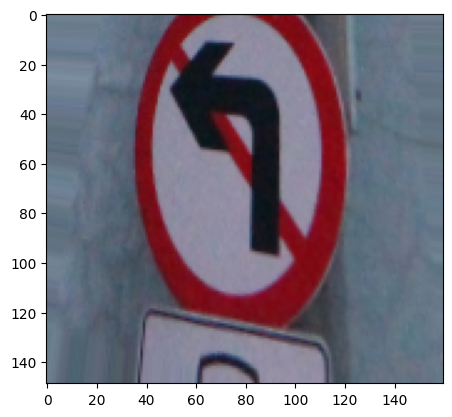

In [118]:
plt.imshow(transform_shapes(np.array([img])).projection_transform(1,0.8)[0][:,:,::-1])

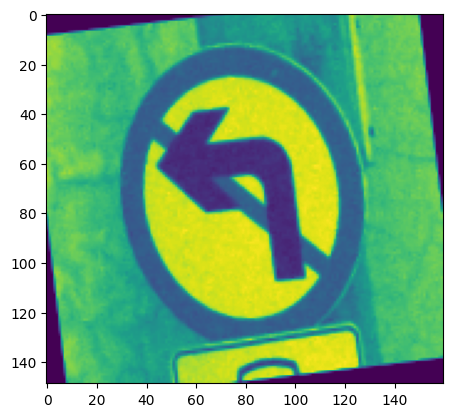

In [147]:
plt.imshow(transform_shapes(np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)])).rotate(nr_sampl=1,nr_per_sample=1,
            max_ang=25,min_ang=-25,maxi=1, mini = .8)[0])

In [124]:
img.shape

(149, 160, 3)